In [31]:
%matplotlib inline

In [79]:
import tensorflow as tf
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
import datetime
from collections import Counter

# Helpful Functions

In [2]:
def cleanURL(url):
    p = pathlib.Path(url)
    path = str(p.as_posix()) 
    return path 


def getDF(loc, sheetname):
    dataframe = pd.read_excel(loc, sheetname)
    #https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
    dataframe = dataframe.applymap(lambda x: x.strip() if type(x) is str else x)
    return dataframe

def printNulls(df):
    null_columns = df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum() 


def writeDFToFile(dfs, path_): #dfs is an array of dataframes and their sheet names , path needs to have
    time_ = str(datetime.datetime.now())
    current_date_time = time_[0:time_.index(".")]
    current_date_time = current_date_time.replace(":", "-")
    task4_fileoutput = path_+current_date_time+".xlsx"

    writer = pd.ExcelWriter(task4_fileoutput)
    
    for df_tuple in dfs:  
        df = df_tuple[0]
        sheetName = df_tuple[1]
        df.to_excel(writer, sheetName)
    print("file written to :       " + task4_fileoutput)
    writer.save()
cwd = os.getcwd()
cwd

'/home/muhammadayub/Desktop/CS230/Notebooks/re'

# Load Data

### Using the data loader methodology:

In [19]:
################
# Constants 
################
BATCHSIZE_Y = 3000
LAST_BATCHSIZE_Y = 3000
TIMES_OF_DAY = 24
#The last day since the LEntries data only goes to 6/20/2018, we should filter to that end 
LAST_DAY = 6350 # in terms of timedelta.days
#FIRST_DAY was 1/1/2001, last day should then be 6/30/2018
MINIBATCHES_AMT = 762 #or (200,762) (254 batches of 600) (gcf of 3000 and 152400) # keep in mind that this number is going to be scaled by 16 since 16 64by64 images are in one 256by256
#150 or 1016              #batch size should never be more than 2900 (really 3000, but to stay on the safe side)
iHeight = 256
iWidth = 256


################
# Load all the data , for the larger data values , just run  
################

# load all the data #CHANGEME
# datesb = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\dates_data_b.npy'))
# dates = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\dates_data.npy'))
# buildings = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\x__buildings_b.npy'))
datesb = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/dates_data_b.npy'))
dates = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/dates_data.npy'))
buildings = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/x__buildings_b.npy'))



#make sure there are no nan values in buildings 
mask = np.isnan(buildings)
indices = np.where(mask ==True)
z = indices[0]
y = indices[1]
x = indices[2]
buildings[z,y,x] = -1

# businesses = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\x__businesses_b.npy'))
# socio = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\x__socio_b.npy'))
# lentries = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\x__Lentries_c.npy'), mmap_mode  = 'r')
# waterway = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\waterway.npy'))
businesses = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/x__businesses_b.npy'))
socio = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/x__socio_b.npy'))
lentries = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/x__Lentries_c.npy'))#, mmap_mode  = 'r')#CHANGEME
waterway = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/waterway.npy'))
##KLUDGE: This is a quick fix, just set a lot of the data to 0
waterway[:,170:]= 1

#get all the masks used

################
# Preprocess every image value to be its transpose
################
# buildings  buildingsT -> buildingsTStacked
# businesses    businessesT -> businessesTStacked
# socio   socioT -> socioTStacked
buildingsT= transpose3dImage(buildings)
businessesT= transpose3dImage(businesses)
socioT = transpose3dImage(socio)

print('done')

done


In [7]:
#load all the outputs
outputsData =[]
for i_ in range(1, 53):
    y_ = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\y__c'+str(i_)+'_c.npy'), mmap_mode  = 'r')
    outputsData.append(y_)

In [10]:
# if we have enough RAM ( 40 GB worth after we have added everything else) , combine every output to one big ndarray 
# this results in huge speed up
# if at all possible  #CHANGEME
outputsDataReal = np.concatenate(outputsData, axis = 0)
print(outputsDataReal.shape)
for i_ in range(len(outputsData)):
    outputsData[i_] =None
    
# if at all possible  #CHANGEME
for i_ in range(len(outputsDataReal)):
    outputsDataReal[i_] =outputsDataReal[i_].T
print('run once')
# print(outputsDataReal.max())#33 is max, 0 is min
# print(outputsDataReal.min())

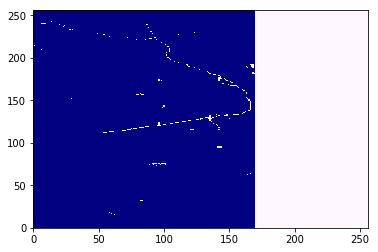

In [129]:
# waterway was not working, for the time being, simply remove right portion of the images
waterway = np.load(cleanURL(r'/home/muhammadayub/Desktop/CS230/training_data/waterway.npy'))
# waterway2=np.array(waterway)
waterway[:,170:]= 1
plotImg(waterway)

In [37]:
# to print the waterway mask
import matplotlib.pyplot as plt
import numpy as np

def plotImg(img):
    if(type(img) ==type(None)):
        img =outputsDataReal[10000]
    arr = []
    for a in img:
        arr = [a] + arr
    plt.pcolor( arr, cmap = 'gist_ncar' )

    plt.show()

In [39]:
### outputs are very sparse
abc = np.where(outputsDataReal[1000:10000] !=0)
# plotImg(outputsDataReal[1000])
len(abc[0])

4833

### Cleaning up the data (to align all the indices of the data)

In [ ]:
lentries.shape
print(len(lentries)*24)
print(len(lentries))
# len of everything 
print('number of outputs ' , BATCHSIZE_Y*51+len(outputsData[-1])) # number of outputs , wont work if you combine outputsData to one

In [21]:

# calculate the exact value of how many (256 by 256 by numlayer) images we should have 
indices = LAST_DAY* TIMES_OF_DAY
indices_ = np.array([index for index in range(indices)])
print('Actual data points', len(indices_)) # 0 - 153,335 or 153,336 values                      #152400
print("will shave off extra data. Everything starts from the same point in time")


Actual data points 152400
will shave off extra data. Everything starts from the same point in time


#### Generate minibatches. Shuffle the minibatches, have a function to return a minibatch of X and Y

In [46]:
#get the split of the train/dev/test -> 90, 5, 5
print(MINIBATCHES_AMT)
train_split = int(MINIBATCHES_AMT*.90)
dev_split = int(MINIBATCHES_AMT*.05)
test_split = MINIBATCHES_AMT - train_split - dev_split

print(train_split, dev_split, test_split)
assert(train_split + dev_split + test_split == len(MINIBATCHES_AMT))

762
685 38 39


In [55]:
print('Indices of datapoints', indices_)
#gets the indices of the minibatches

minibatches = np.split(indices_,MINIBATCHES_AMT)

devMiniBatches = minibatches[train_split:train_split+dev_split]
testMiniBatches = minibatches[train_split+dev_split:]
minibatches = minibatches[:train_split] #training set  #must be at the end

# sample = np.array(minibatches[0])
# print('sample minibatch: ' , sample )
# #to shuffle the minibatches for random minibatches  we will do this every epoch
# np.random.shuffle(minibatches)
# print(devMiniBatches)
# print(testMiniBatches)

Indices of datapoints [     0      1      2 ... 152397 152398 152399]


In [136]:
# datesb -- no need 
# dates -- no need
# buildings  buildingsT -> buildingsTStacked
# businesses    businessesT -> businessesTStacked
# socio   socioT -> socioTStacked
# lentries 
# waterway  -- not part of data 
# outputsData 


#next steps -> add lentries, temperature, and masks 

# now we write a function that will return to us the correct minibatch , with all the image data generated
def generateMinibatch(minibatchIndices):    #everything must be transposed
    #general steps:
    #get the x inputs
    #    same as the file of text 
    
    #step 1. dates (make 12 layers of month, day, year , timeOfDay)  # dateLayers don't need to be transposed -> just 1 value
    dateLayers = generateDatesLayers(minibatchIndices, datesb) # (150, 256, 256, 4)  => len(minibatchIndices) = 150
    
    #step 2. Buildings 10 layers 
    buildingLayers = stackManyTimes(buildingsT, len(minibatchIndices))  # buildingsT should be (256,256,10) and result should (150, 256, 256, 10)
  
    #step 3. 
    businessesLayers = stackManyTimes(businessesT, len(minibatchIndices))
    
    #step 4. L entries
    #come back to this one   => must be transposed!!!
    LentryLayers = None
    
    #step 5. socio
    socioLayers = stackManyTimes(socioT, len(minibatchIndices))
    
    #step 6. temperature #should be format of
    #pass on this for now -> will add this for later iterations
    
    #step 7. concat everything
    inputImage = np.concatenate((dateLayers,buildingLayers,businessesLayers,socioLayers) , axis = -1)
    #     print(np.where((inputImage[:4]==dateLayers)==False))
    #     print(np.where((inputImage[4:14]==buildingLayers)==False))

    #step 7. outputs
    output_image = outputsDataReal[minibatchIndices]  # calculateOutput(minibatchIndices)
    return inputImage, output_image#, waterway

def generateDatesLayers(minibatchIndices, datesb):  # makes (n , 256, 256, 4) -> n 4 layer images
    base_img_mask = np.ones((256, 256), dtype=np.float32)
    xy = np.dstack([base_img_mask]*4) # shape (256, 256, 4)
    dateLayers = datesb[minibatchIndices] # (len(minibatchIndices) , 4)
    dateLayersReshaped = dateLayers.reshape((len(dateLayers), 1,1,dateLayers.shape[1])) # (len(minibatchIndices),1,1 , 4)
    xyz = xy* dateLayersReshaped 
    return xyz

def transpose3dImage(img):  #transpose an image 
    img_T = img.T #tested this actually does what we wante it to do.  
    return img_T


def stackManyTimes(_3dimg,times):  # stacks a 3d image "times" times
    _3dimg_shape = _3dimg.shape
    result = np.zeros(shape=(times, _3dimg_shape[0], _3dimg_shape[1],_3dimg_shape[2] ), dtype=np.float32)
    for x in range(times):
        result[x] = _3dimg
    return result

def calculateOutput(sample):  #returns the output image (n, 256,256)
    batchMin = min(sample)#67050
    batchMax = max(sample)#67199
    #     batchMax  = 69050
    #print("batch min " , batchMin," batch max ", batchMax )
    remMin = batchMin % BATCHSIZE_Y
    multipleMin = int(batchMin / BATCHSIZE_Y)

    remMax = batchMax % BATCHSIZE_Y
    multipleMax = int(batchMax / BATCHSIZE_Y)
    
    batch = None
    if(multipleMin != multipleMax):# have to concatenate  batch size can never be more than 3000#
        print('here')
        batch = np.concatenate((outputsData[multipleMin],outputsData[multipleMax]), axis = 0)
    else:
        print('not here')
        batch = outputsData[multipleMin]

    offset = multipleMin*BATCHSIZE_Y
    sample_ = np.array(sample)-offset
    data_output = batch[sample_]
    return data_output

def splitWaterWay(waterwayImg):  # this will make waterway image into (16,64,64)
    imagesList = np.split(waterwayImg, 4, axis = 0)
    images64by64 = []

    for almostImage in imagesList:
        imagesList64by64 = np.split(almostImage, 4, axis = 1) # axis is 0, 1, 2
        for actual64by64 in imagesList64by64:
            images64by64.append(actual64by64)
    #     for i,_64 in enumerate(images64by64):
    #         print(i, _64.shape)
    return np.concatenate(images64by64, axis = 0)

def split256by256StackOnAxis(inputImg):  #returns the images in (64 , 64, numberOfChannels)
    imagesList = np.split(inputImg, 4, axis = 1)
    images64by64 = []

    for almostImage in imagesList:
        imagesList64by64 = np.split(almostImage, 4, axis = 2) # axis is 0, 1, 2
        for actual64by64 in imagesList64by64:
            images64by64.append(actual64by64)
    #     for i,_64 in enumerate(images64by64):
    #         print(i, _64.shape)
    return np.concatenate(images64by64, axis = 0)

def getOutputYVector(y_output_image64, numCats): # y_output_image64 is of shape (3200,64,64)  , 34 categories + -1
    result = np.zeros((len(y_output_image64), numCats), dtype=np.float32)
    cCount = None 
    for i_, img in enumerate(y_output_image64):
        cCount = Counter(img.flatten())
        result[i_][int(cCount.most_common()[0][0])] = 1
        #get the argmax for now  -1 goes to 0, 0 goes to 1, etc. until you have 33 going to 34   -> kludge need to set this to -1
#         result[i_][int(cCount.most_common()[0][0])+1] = 1
    return result


def transformTo64(inputImage, output_image, numCats): # helper method to turn inputData and outputData (256by256) into the 64by64 image
    inputImage64 =  split256by256StackOnAxis(inputImage)
    output_image64 = split256by256StackOnAxis(output_image)
    output_image64 = getOutputYVector(output_image64, numCats) #34 categories since we use -1s, but then shave them off
    return inputImage64, output_image64

def generateWaterWayMask(waterway, threshold):# between 0 and 4096, need atmost 'threshold' to be water 
    sizeOfOneMiniBatch = int(len(indices_)/MINIBATCHES_AMT)
    waterwayMask = np.zeros((sizeOfOneMiniBatch, 256,256), dtype=np.float32)
    for i_ in range(len(waterwayMask)):
        waterwayMask[i_] = waterway
        
    #now that we have the ( 200, 256,256)  (sizeOfOneMiniBatch is 200 for example)
    #we can break it up into the 64 by 64 images
    waterwayMask64 = split256by256StackOnAxis(waterwayMask)
    #from here, you count up each one of the 64 by 64 images and set to the threshold
    waterwayMaskIndices = [] # include if they are one 
    for i_ in range(len(waterwayMask64)):
        if(np.sum(waterwayMask64[i_]) <= threshold): #> would mean you have more 1's than allowed -> not tolerable 
            waterwayMaskIndices.append(i_)
    return waterwayMaskIndices

# Model Definition (based off research paper)

In [98]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(shape =[None, n_H0, n_W0, n_C0], dtype = np.float32, name="X")
    Y = tf.placeholder(shape  =[None, n_y], dtype = np.float32 , name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [154]:
X, Y = create_placeholders(64, 64, 26, 34)  #will have 35 , 34 real values and 1 fake value
print ("X = " + str(X))
print ("Y = " + str(Y))


X = Tensor("X_1:0", shape=(?, 64, 64, 26), dtype=float32)
Y = Tensor("Y_1:0", shape=(?, 34), dtype=float32)


## First CNN Trial

### First filter shape: (10 , 10,3 , 3) stride = 2, valid padding
    
    (64 +2p - f)/s +1 => (64+0-10)/2+1 = 28
    So, (?, 64, 64, 3) * (10 , 10 , 3,  3) = (?, 28, 28, 3 )
    
### Average Pooling Layer: (3 , 3 , 3) stride = 1, Padding = SAME
    
    (28 +2p - f)/s +1 => (28+2*1-3)/1+1 = 28
    So, (?, 28, 28, 3) * ( 3 , 3,  3) = (?, 28, 28, 3 )
    
    
### Second filter shape: (6 , 6 ,3, 2) stride = 2, valid padding
    
    (28 +2p - f)/s +1 => (28+0-6)/2+1 = 12
    So, (?, 28, 28, 3) * (6 , 6 , 3, 2) = (?, 12, 12, 2)
    
### Max Pooling layer valid padding stride 1 (3,3)
    
    (12 +2p - f)/s +1 => (12+0-3)/1+1 = 10
    So, (?, 12,12, 2) * (3, 3 , 2, 2) = (?, 10, 10, 2)

    
### Fourth filter shape: Flatten , fully connected (10*10*2) = 200
    
    W3 = 36 by 200
    
### Softmax function for evaluation    


In [159]:
def initialize_parameters():    

    W1 = tf.get_variable("W1", [10, 10, 26, 3], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [6, 6, 3, 2], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [35,200] , initializer =tf.contrib.layers.xavier_initializer(seed = 0) )

    parameters = {"W1": W1, "W2": W2 , 'W3': 'W3'}
    
    return parameters

In [162]:
def forward_prop(X, params):
    W1 = params['W1']
    W2 = params['W2']    
    W3 = params['W3']
    
    #convolution 
    Z1 = tf.nn.conv2d(X,W1, strides = [1,2,2,1], padding = 'VALID')
    
    #bias added automatically # RELU
    A1 = tf.nn.relu(Z1)
    
    #average pooling -> at this point all features/weights are important to us
    P1 = tf.nn.avg_pool(A1, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'SAME')

    # convolution 
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,2,2,1], padding = 'VALID')
    
    #RELU
    A2 = tf.nn.relu(Z2)
    
    #max pooling
    P2 = tf.nn.max_pool(A2, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'VALID')
    
    #flatten
    P2 = tf.contrib.layers.flatten(P2)

    #fully connected
    Z3 = tf.contrib.layers.fully_connected(P2, 34, activation_fn = None) #1 for yes/no
    #going to add the softmax directly

    return Z3

# Run or Train the model

In [165]:
tf.reset_default_graph()

learning_rate = .008
costs = []
num_epochs = 20

WaterWayMask = generateWaterWayMask(waterway, 400)# the constants must be called before running this


# # Initialize all the variables globally
# init = tf.global_variables_initializer()

# Start the session to compute the tensorflow graph
with tf.Session() as sess:

    #the model
    X, Y = create_placeholders(64, 64, 26, 34)
    parameters = initialize_parameters()
    Z3 = forward_prop(X, parameters)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)
    
    #init must be after optimizer
    init = tf.global_variables_initializer()

    
    # Run the initialization
    sess.run(init)
    print('Starting ' , datetime.datetime.now())
    # Do the training loop
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        np.random.shuffle(minibatches) # get new minibatch results 

        for minibatch in minibatches:

            # Select a minibatch
            inputImage, output_image = generateMinibatch(minibatches[10])
            inputImage64, output_image64 = transformTo64(inputImage, output_image,34)
            output_image64 = output_image64[WaterWayMask]
            inputImage64 = inputImage64[WaterWayMask]
            
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
            ### START CODE HERE ### (1 line)
            _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: inputImage64, Y: output_image64})
            ### END CODE HERE ###

            minibatch_cost += temp_cost / MINIBATCHES_AMT

            print('Minibatch End: ', datetime.datetime.now())
        
        
        costs.append(minibatch_cost)
        print('Epoch End: ', datetime.datetime.now())
        
    
        

Starting  2018-12-06 19:06:21.262765


/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


(array([0]),)
(array([0]),)
Minibatch End:  2018-12-06 19:06:32.130429
(array([0]),)
(array([0]),)
Minibatch End:  2018-12-06 19:06:42.969363
Epoch End:  2018-12-06 19:06:42.969502


Looking at data generated

In [148]:
print(datetime.datetime.now())
WaterWayMask = generateWaterWayMask(waterway, 400)
inputImage, output_image = generateMinibatch(minibatches[10])
# print(inputImage.dtype)
# print(output_image.dtype)
inputImage64, output_image64 = transformTo64(inputImage, output_image,34)
# print(inputImage64.dtype)
# print(output_image64.dtype)
output_image64 = output_image64[WaterWayMask]
inputImage64 = inputImage64[WaterWayMask]
# print(inputImage64.dtype)
# print(output_image64.dtype)
print(datetime.datetime.now())


2018-12-06 18:59:36.103546


/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


(array([0]),)
(array([0]),)
2018-12-06 18:59:43.296475


In [143]:
print(inputImage64.shape)
print(output_image64.shape)
print(inputImage64.dtype)
print(output_image64.dtype)
print(len(WaterWayMask))

(1600, 64, 64, 26)
(1600, 34)
float64
float64
1600


# For back up testing and everything  --> no need to look at this 

In [96]:
# print(output_image.shape)

# output = getOutputYVector(output_image,34)
# print(output.shape)
# output[0]

# result = np.zeros((len(output_image), 34))
# cCount = None 
# for i_, img in enumerate(output_image):
#     cCount = Counter(img.flatten())

(3200, 64, 64)
(3200, 34)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Generating Water Way Mask

In [128]:
def generateWaterWayMask(waterway, threshold):# between 0 and 4096, need atmost 200 to be water 
    sizeOfOneMiniBatch = int(len(indices_)/MINIBATCHES_AMT)
    waterwayMask = np.zeros((sizeOfOneMiniBatch, 256,256), dtype=np.float32)
    for i_ in range(len(waterwayMask)):
        waterwayMask[i_] = waterway
        
    #now that we have the ( 200, 256,256)  (sizeOfOneMiniBatch is 200 for example)
    #we can break it up into the 64 by 64 images
    waterwayMask64 = split256by256StackOnAxis(waterwayMask)
    #from here, you count up each one of the 64 by 64 images and set to the threshold
    waterwayMaskIndices = [] # include if they are one 
    for i_ in range(len(waterwayMask64)):
        if(np.sum(waterwayMask64[i_]) <= threshold): #> would mean you have more 1's than allowed -> not tolerable 
            waterwayMaskIndices.append(i_)
    return waterwayMaskIndices

ww = np.ones((256,256))
ww[:64, (256-64):] = 0

abc = generateWaterWayMask(ww, 5)
len(abc)
print(abc)  # think it works 

# len(minibatches[10])
#stack waterway image by 

[600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799]

for getting the output data (1 hot encoded vectors)

In [95]:
def split256by256StackOnAxis(inputImg):
    imagesList = np.split(inputImg, 4, axis = 1)
    images64by64 = []

    for almostImage in imagesList:
        imagesList64by64 = np.split(almostImage, 4, axis = 2) # axis is 0, 1, 2
        for actual64by64 in imagesList64by64:
            images64by64.append(actual64by64)
    #     for i,_64 in enumerate(images64by64):
    #         print(i, _64.shape)
    return np.concatenate(images64by64, axis = 0)

def getOutputYVector(y_output_image64, numCats): # y_output_image64 is of shape (3200,64,64)  , 34 categories + -1
    result = np.zeros((len(y_output_image64), numCats), dtype=np.float32)
    cCount = None 
    for i_, img in enumerate(y_output_image64):
        cCount = Counter(img.flatten())
        result[i_][int(cCount.most_common()[0][0])] = 1
        #get the argmax for now  -1 goes to 0, 0 goes to 1, etc. until you have 33 going to 34
#         result[i_][int(cCount.most_common()[0][0])+1] = 1
    return result

Testing Dates

In [154]:
#exploring things
base_img_mask = np.ones((2, 2), dtype=np.float32)
print(base_img_mask.shape)
base_img_mask[0,0] = 1
base_img_mask[0,1] = 2
base_img_mask[1,0] = 3
base_img_mask[1,1] = 4

base_img_mask

np.array([base_img_mask]*4)

(2, 2)


array([[[1., 2.],
        [3., 4.]],

       [[1., 2.],
        [3., 4.]],

       [[1., 2.],
        [3., 4.]],

       [[1., 2.],
        [3., 4.]]], dtype=float32)

Testing Copy Generation of an image ( numLayers, 256, 256) to  (256, 256, numLayers) and then to  (sampleNum, 256, 256, numLayers) 

In [214]:
###Testing Dates 

base_img_mask = np.ones((256, 256), dtype=np.float32)
xy = np.dstack([base_img_mask]*4)
print(xy.shape)

dateLayers = datesb[minibatchIndices]
print(dateLayers.shape)
dateLayersReshaped = dateLayers.reshape((len(dateLayers), 1,1,dateLayers.shape[1]))
print(dateLayersReshaped.shape)


xyz = xy* dateLayersReshaped 
xyz.shape

#do some checks 
firstVal = dateLayers[45][1] #last layer, 2nd d value
print(firstVal)

print(set(xyz[45, :,:, 1].flatten()))
#change the 45 and the 1 and see if things match! 

def generateDatesLayers(minibatchIndices, datesb):
    base_img_mask = np.ones((256, 256), dtype=np.float32)
    xy = np.dstack([base_img_mask]*4) # shape (256, 256, 4)
    dateLayers = datesb[minibatchIndices] # (len(minibatchIndices) , 4)
    dateLayersReshaped = dateLayers.reshape((len(dateLayers), 1,1,dateLayers.shape[1])) # (len(minibatchIndices),1,1 , 4)
    xyz = xy* dateLayersReshaped 
    return xyz

    

(256, 256, 4)
(150, 4)
(150, 1, 1, 4)
-0.4995
{-0.4995}


In [229]:
# Removing Null values
mask = np.isnan(buildings)
indices = np.where(mask ==True)
z = indices[0]
y = indices[1]
x = indices[2]
buildings[z,y,x] = -1

# mask2 = np.isnan(buildingsTest)
# indices2 = np.where(mask2 ==True)
# print(indices2)
# print(len(indices))
# print((indices[0].flatten().tolist()))

In [18]:
#For transposing images 

testData = np.array([[[1,2],[3,4]],
                    [[5,6],[7,8]],
                    [[9,10],[11,12]]])
print(testData)
print(testData.shape)

def transpose3dImage(img):
    img_T = img.T #tested this actually does what we wante it to do.  
    return img_T

testDataT = transpose3dImage(testData) # ( numLayers, 256, 256) to (256, 256, numLayers) 

print(testDataT[:,:,1])
print(testDataT.shape)
# dateLayers = generateDatesLayers(minibatchIndices, datesb)
# dateLayers.shape

[[[ 1  2]
  [ 3  4]]

 [[ 5  6]
  [ 7  8]]

 [[ 9 10]
  [11 12]]]
(3, 2, 2)
[[5 7]
 [6 8]]
(2, 2, 3)


In [270]:
# For  (256, 256, numLayers) and then to (sampleNum, 256, 256, numLayers) 

def stackManyTimes(_3dimg,times):
    _3dimg_shape = _3dimg.shape
    result = np.zeros(shape=(times, _3dimg_shape[0], _3dimg_shape[1],_3dimg_shape[2] ), dtype=np.float32)
    for x in range(times):
        result[x] = _3dimg
    return result
    
buildings2 = np.array(transpose3dImage(buildings))
print(buildings2.shape)

buildings3_multiplied = stackManyTimes(buildings2, 4)
print(buildings3_multiplied.shape)

np.where((buildings3_multiplied[3]==buildings2) == False)

(256, 256, 10)
(4, 256, 256, 10)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

### Getting the right output from the list of 52, given that we know that batch size is 

In [315]:
# Getting the right output from the list of 52, we know that batch size is 
# print(minibatchIndices[])
# dateLayers[-1][2]
print(len(outputsData))

outputsData[51].shape

sample = minibatches[0]
batchMin = min(sample)#67050
batchMax = max(sample)#67199
batchMax  = 69050
print("batch min " , batchMin," batch max ", batchMax )
remMin = batchMin % BATCHSIZE_Y
multipleMin = int(batchMin / BATCHSIZE_Y)

remMax = batchMax % BATCHSIZE_Y
multipleMax = int(batchMax / BATCHSIZE_Y)


print(multipleMin," ",multipleMax)
# outputsData[multipleMin-1] # 1 is really 0, 2 is really 1 , and so on. 


# batchMin
#152300 - 152399
# 155900 to 155917
int(155900/BATCHSIZE_Y)
print(remMax)

52
batch min  151200  batch max  69050
50   23
50


In [316]:
batch = None
if(multipleMin != multipleMax):# have to concatenate  batch size can never be more than 3000#
    print('here')
    batch = np.concatenate((outputsData[multipleMin],outputsData[multipleMax]), axis = 0)
else:
    print('not here')
    batch = outputsData[multipleMin]
    
offset = multipleMin*BATCHSIZE_Y#+remMin

print(offset)
batch.shape
sample_ = np.array(sample)-offset

data_output = batch[sample_]


here
150000


In [310]:
data_output.shape

#very sure that we have to transpose everything -> since we transposed everything in the input layer 
for i_, img in enumerate(data_output):
    data_output[i_] = img.T

#now we make the 16, by 16 images 

sample = minibatches[0]

def calculateOutput(sample):
    batchMin = min(sample)#67050
    batchMax = max(sample)#67199
    #     batchMax  = 69050
    #print("batch min " , batchMin," batch max ", batchMax )
    remMin = batchMin % BATCHSIZE_Y
    multipleMin = int(batchMin / BATCHSIZE_Y)

    remMax = batchMax % BATCHSIZE_Y
    multipleMax = int(batchMax / BATCHSIZE_Y)
    
    batch = None
    if(multipleMin != multipleMax):# have to concatenate  batch size can never be more than 3000#
        print('here')
        batch = np.concatenate((outputsData[multipleMin],outputsData[multipleMax]), axis = 0)
    else:
        print('not here')
        batch = outputsData[multipleMin]

    offset = multipleMin*BATCHSIZE_Y
    sample_ = np.array(sample)-offset
    data_output = batch[sample_]
    return data_output


output_images = calculateOutput(sample)
output_images.shape
#( numLayers, 256, 256) to (256, 256, numLayers) 
#testDataT = transpose3dImage(testData)

not here


In [16]:
tf.reset_default_graph()

learning_rate = .008
costs = []
with tf.Session() as sess:
    
    X, Y = create_placeholders(64, 64, 3, 35)
    parameters = initialize_parameters()
    Z3 = forward_prop(X, parameters)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)
    #init must be after optimizer
    init = tf.global_variables_initializer()

    sess.run(init)
    
    for epoch in range(10):
        _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: np.random.randn(2,64,64,3), Y: np.random.randn(2,35)})
        costs.append(temp_cost)
        
        
    #     a = sess.run(cost, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,35)})
    #     print("Z3 = " + str(a))
costs

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



[6.140359,
 3.24087,
 15.307369,
 -15.310234,
 6.9300766,
 9.067983,
 -29.766876,
 6.4712744,
 27.031092,
 17.86364]

In [10]:
# zipLoc = cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\New folder\drive-download-20181203T055115Z-005.zip')
# directory = cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\New folder\\')+'/'

# print(zipLoc)
# print(directory)
# with zipfile.ZipFile(zipLoc, 'r') as zip_ref:
#     zip_ref.extractall(directory)
# a = np.load(cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\New folder\x__buildings_.npy'))
# #b = cleanURL(r'C:\Users\User\Documents\CS230 Project\new_github\data_for_cnn_training\New folder\y__c16_.npy')
# #a = np.load(b)
# a.shape

In [74]:
# inputImage, output_image, waterway = generateMinibatch(minibatches[10])
#inputImage, output_image = generateMinibatch(minibatches[10])

(array([0]),)
(array([0]),)


/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
